<a href="https://colab.research.google.com/github/Skander28/LastWork/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00


In [2]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
  !nvidia-smi
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mon May 29 14:22:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [3]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Read the given dataset which contain the Ids
filtered_df = pd.read_csv('/content/drive/MyDrive/LastTry.csv',lineterminator='\n')
filtered_df.head()

Mounted at /content/drive


,Unnamed: 0,id,text,dialect,word_count,char_count
0,0,1152861142416576384,طيب اعرفو رئيس وزرائكم الاول وتعالو حاسبو رياض...,DZ,9,57
1,1,921392744878264448,@khaireddineroub اوكي ماتنساش روراوة ثاني لازم...,DZ,16,94
2,2,960133615689576448,@safasafa2339 يا ختي ديجا كي نشوف سمو نبدا نرج...,DZ,12,54
3,3,1121522092581769216,حسابشخصي حسابشخصي حسابشخصي اوو وش لي مش وخدين ...,DZ,10,54
4,4,1187345510874656768,@Hadjer12345678 تقولي راكي تهدري عليا 😂😂😂,DZ,6,41


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [5]:
import sentencepiece as spm

text_data = filtered_df['text'].tolist()

with open('tweets.txt', 'w', encoding='utf-8') as file:
    for tweet in text_data:
        file.write(tweet + '\n')
  
# Define the SentencePiece model path and vocabulary size
model_prefix = 'maghrebi_model'
vocab_size = 25000
max_length = 200

# Train the SentencePiece tokenizer
spm.SentencePieceTrainer.train(
    f'--input=tweets.txt --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type=unigram'
)

from torch.nn.utils.rnn import pad_sequence
# Load the trained SentencePiece tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f'{model_prefix}.model')

# Tokenize the text data
tokenized_data = [tokenizer.encode(text) for text in text_data]
tokenized_data = pad_sequences(tokenized_data, maxlen=max_length)

In [6]:
labels = pd.get_dummies(filtered_df['dialect']).values

In [7]:
# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(tokenized_data, labels, test_size=0.05, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, shuffle=True)


In [8]:
import numpy as np

# Convert the one-hot encoded labels back to dialect labels
dialect_labels = np.argmax(labels, axis=1)
# Get the unique dialect labels and their counts in the original dataset
unique_dialects, dialect_counts = np.unique(dialect_labels, return_counts=True)

# Get the number of samples for each dialect in the training set
train_dialect_labels = np.argmax(y_train, axis=1)
train_dialect_counts = np.bincount(train_dialect_labels, minlength=len(unique_dialects))

# Get the number of samples for each dialect in the validation set
val_dialect_labels = np.argmax(y_val, axis=1)
val_dialect_counts = np.bincount(val_dialect_labels, minlength=len(unique_dialects))

# Get the number of samples for each dialect in the test set
test_dialect_labels = np.argmax(y_test, axis=1)
test_dialect_counts = np.bincount(test_dialect_labels, minlength=len(unique_dialects))

# Map dialect labels to their corresponding names
dialect_names = ["DZ", "LY", "MA", "TN"] 

# Print the number of samples for each dialect in each set
for dialect, train_count, val_count, test_count in zip(unique_dialects, train_dialect_counts, val_dialect_counts, test_dialect_counts):
    dialect_name = dialect_names[dialect]
    print(f"{dialect_name}: Train={train_count}, Val={val_count}, Test={test_count}")

DZ: Train=16283, Val=860, Test=864
LY: Train=16251, Val=834, Test=922
MA: Train=16210, Val=866, Test=931
TN: Train=16260, Val=862, Test=885


In [9]:
# Convert data to PyTorch tensors
X_train_, y_train_ = torch.tensor(X_train), torch.tensor(y_train)
X_val_, y_val_ = torch.tensor(X_val), torch.tensor(y_val)
X_test_, y_test_ = torch.tensor(X_test), torch.tensor(y_test)

In [10]:
class DialectDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
# Create dataloaders for training, validation, and test sets
train_dataset = DialectDataset(X_train_, y_train_)
val_dataset = DialectDataset(X_val_, y_val_)
test_dataset = DialectDataset(X_test_, y_test_)

In [12]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


# **LSTM Model**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

emb_dim = 100
batch_size = 64


class MyModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, max_length):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.lstm = nn.LSTM(emb_dim, 100,num_layers = 2, dropout=0.3, batch_first=True)
        # self.lstm2 = nn.LSTM(100, 50, dropout=0.3, batch_first=True)
        self.linear = nn.Linear(100, 4)
        softmax = nn.Softmax(dim=1)
        self.fc = nn.Sequential(self.linear, softmax)
    
    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        lstm_out, _ = self.lstm(dropped)
        # lstm2_out, _ = self.lstm2(lstm_out)
        out = self.fc(lstm_out[:, -1, :])
        return out
     

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel(vocab_size, emb_dim, max_length).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.BCEWithLogitsLoss()

best_val_loss = float('inf')
patience = 8
early_stopping_counter = 0

for epoch in tqdm(range(100)):
    model.train()
    running_loss = 0.0
    with torch.cuda.device(0):
      for batch in train_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        labels = labels.float()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / (len(train_dataloader))

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            labels = labels.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    print("Epoch: {}/{} | Train Loss: {:.4f} | Val Loss: {:.4f}".format(epoch+1, 100, epoch_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break
        

  1%|          | 1/100 [00:12<20:43, 12.56s/it]

Epoch: 1/100 | Train Loss: 0.7455 | Val Loss: 0.7237


  2%|▏         | 2/100 [00:23<19:22, 11.86s/it]

Epoch: 2/100 | Train Loss: 0.7221 | Val Loss: 0.7038


  3%|▎         | 3/100 [00:35<18:55, 11.70s/it]

Epoch: 3/100 | Train Loss: 0.7074 | Val Loss: 0.6931


  4%|▍         | 4/100 [00:47<18:38, 11.65s/it]

Epoch: 4/100 | Train Loss: 0.6956 | Val Loss: 0.6875


  5%|▌         | 5/100 [00:58<18:25, 11.64s/it]

Epoch: 5/100 | Train Loss: 0.6887 | Val Loss: 0.6775


  6%|▌         | 6/100 [01:11<18:48, 12.01s/it]

Epoch: 6/100 | Train Loss: 0.6818 | Val Loss: 0.6746


  7%|▋         | 7/100 [01:23<18:27, 11.91s/it]

Epoch: 7/100 | Train Loss: 0.6771 | Val Loss: 0.6729


  8%|▊         | 8/100 [01:34<18:10, 11.86s/it]

Epoch: 8/100 | Train Loss: 0.6734 | Val Loss: 0.6669


  9%|▉         | 9/100 [01:46<17:55, 11.81s/it]

Epoch: 9/100 | Train Loss: 0.6689 | Val Loss: 0.6661


 10%|█         | 10/100 [01:58<17:41, 11.80s/it]

Epoch: 10/100 | Train Loss: 0.6656 | Val Loss: 0.6649


 11%|█         | 11/100 [02:10<17:31, 11.81s/it]

Epoch: 11/100 | Train Loss: 0.6629 | Val Loss: 0.6621


 12%|█▏        | 12/100 [02:22<17:21, 11.83s/it]

Epoch: 12/100 | Train Loss: 0.6605 | Val Loss: 0.6596


 13%|█▎        | 13/100 [02:33<17:11, 11.85s/it]

Epoch: 13/100 | Train Loss: 0.6586 | Val Loss: 0.6601


 14%|█▍        | 14/100 [02:45<17:00, 11.87s/it]

Epoch: 14/100 | Train Loss: 0.6564 | Val Loss: 0.6591


 15%|█▌        | 15/100 [02:57<16:51, 11.89s/it]

Epoch: 15/100 | Train Loss: 0.6546 | Val Loss: 0.6571


 16%|█▌        | 16/100 [03:09<16:40, 11.91s/it]

Epoch: 16/100 | Train Loss: 0.6529 | Val Loss: 0.6567


 17%|█▋        | 17/100 [03:21<16:30, 11.94s/it]

Epoch: 17/100 | Train Loss: 0.6512 | Val Loss: 0.6563


 18%|█▊        | 18/100 [03:33<16:21, 11.96s/it]

Epoch: 18/100 | Train Loss: 0.6505 | Val Loss: 0.6571


 19%|█▉        | 19/100 [03:45<16:10, 11.98s/it]

Epoch: 19/100 | Train Loss: 0.6489 | Val Loss: 0.6566


 20%|██        | 20/100 [03:57<15:59, 12.00s/it]

Epoch: 20/100 | Train Loss: 0.6472 | Val Loss: 0.6543


 21%|██        | 21/100 [04:09<15:50, 12.03s/it]

Epoch: 21/100 | Train Loss: 0.6458 | Val Loss: 0.6541


 22%|██▏       | 22/100 [04:22<15:40, 12.05s/it]

Epoch: 22/100 | Train Loss: 0.6454 | Val Loss: 0.6532


 23%|██▎       | 23/100 [04:34<15:29, 12.07s/it]

Epoch: 23/100 | Train Loss: 0.6440 | Val Loss: 0.6524


 24%|██▍       | 24/100 [04:46<15:18, 12.08s/it]

Epoch: 24/100 | Train Loss: 0.6429 | Val Loss: 0.6523


 25%|██▌       | 25/100 [04:58<15:07, 12.11s/it]

Epoch: 25/100 | Train Loss: 0.6421 | Val Loss: 0.6527


 26%|██▌       | 26/100 [05:10<14:56, 12.11s/it]

Epoch: 26/100 | Train Loss: 0.6416 | Val Loss: 0.6505


 27%|██▋       | 27/100 [05:22<14:44, 12.12s/it]

Epoch: 27/100 | Train Loss: 0.6406 | Val Loss: 0.6502


 28%|██▊       | 28/100 [05:34<14:33, 12.13s/it]

Epoch: 28/100 | Train Loss: 0.6399 | Val Loss: 0.6499


 29%|██▉       | 29/100 [05:46<14:20, 12.12s/it]

Epoch: 29/100 | Train Loss: 0.6386 | Val Loss: 0.6505


 30%|███       | 30/100 [05:59<14:08, 12.12s/it]

Epoch: 30/100 | Train Loss: 0.6385 | Val Loss: 0.6490


 31%|███       | 31/100 [06:11<13:56, 12.12s/it]

Epoch: 31/100 | Train Loss: 0.6379 | Val Loss: 0.6493


 32%|███▏      | 32/100 [06:23<13:45, 12.14s/it]

Epoch: 32/100 | Train Loss: 0.6368 | Val Loss: 0.6480


 33%|███▎      | 33/100 [06:35<13:34, 12.15s/it]

Epoch: 33/100 | Train Loss: 0.6364 | Val Loss: 0.6479


 34%|███▍      | 34/100 [06:47<13:22, 12.15s/it]

Epoch: 34/100 | Train Loss: 0.6358 | Val Loss: 0.6499


 35%|███▌      | 35/100 [06:59<13:11, 12.18s/it]

Epoch: 35/100 | Train Loss: 0.6350 | Val Loss: 0.6481


 36%|███▌      | 36/100 [07:12<13:00, 12.20s/it]

Epoch: 36/100 | Train Loss: 0.6349 | Val Loss: 0.6480


 37%|███▋      | 37/100 [07:24<12:50, 12.24s/it]

Epoch: 37/100 | Train Loss: 0.6337 | Val Loss: 0.6476


 38%|███▊      | 38/100 [07:36<12:39, 12.25s/it]

Epoch: 38/100 | Train Loss: 0.6333 | Val Loss: 0.6481


 39%|███▉      | 39/100 [07:48<12:26, 12.24s/it]

Epoch: 39/100 | Train Loss: 0.6330 | Val Loss: 0.6470


 40%|████      | 40/100 [08:01<12:13, 12.23s/it]

Epoch: 40/100 | Train Loss: 0.6327 | Val Loss: 0.6466


 41%|████      | 41/100 [08:13<12:01, 12.22s/it]

Epoch: 41/100 | Train Loss: 0.6325 | Val Loss: 0.6467


 42%|████▏     | 42/100 [08:25<11:48, 12.22s/it]

Epoch: 42/100 | Train Loss: 0.6318 | Val Loss: 0.6465


 43%|████▎     | 43/100 [08:37<11:36, 12.22s/it]

Epoch: 43/100 | Train Loss: 0.6310 | Val Loss: 0.6459


 44%|████▍     | 44/100 [08:50<11:25, 12.24s/it]

Epoch: 44/100 | Train Loss: 0.6306 | Val Loss: 0.6453


 45%|████▌     | 45/100 [09:02<11:12, 12.23s/it]

Epoch: 45/100 | Train Loss: 0.6303 | Val Loss: 0.6453


 46%|████▌     | 46/100 [09:14<11:00, 12.22s/it]

Epoch: 46/100 | Train Loss: 0.6301 | Val Loss: 0.6458


 47%|████▋     | 47/100 [09:26<10:47, 12.21s/it]

Epoch: 47/100 | Train Loss: 0.6298 | Val Loss: 0.6458


 48%|████▊     | 48/100 [09:38<10:34, 12.20s/it]

Epoch: 48/100 | Train Loss: 0.6292 | Val Loss: 0.6449


 49%|████▉     | 49/100 [09:51<10:21, 12.19s/it]

Epoch: 49/100 | Train Loss: 0.6289 | Val Loss: 0.6455


 50%|█████     | 50/100 [10:03<10:08, 12.18s/it]

Epoch: 50/100 | Train Loss: 0.6285 | Val Loss: 0.6460


 51%|█████     | 51/100 [10:15<09:56, 12.17s/it]

Epoch: 51/100 | Train Loss: 0.6282 | Val Loss: 0.6455


 52%|█████▏    | 52/100 [10:27<09:43, 12.16s/it]

Epoch: 52/100 | Train Loss: 0.6279 | Val Loss: 0.6449


 53%|█████▎    | 53/100 [10:39<09:31, 12.16s/it]

Epoch: 53/100 | Train Loss: 0.6275 | Val Loss: 0.6438


 54%|█████▍    | 54/100 [10:51<09:20, 12.17s/it]

Epoch: 54/100 | Train Loss: 0.6272 | Val Loss: 0.6443


 55%|█████▌    | 55/100 [11:04<09:07, 12.18s/it]

Epoch: 55/100 | Train Loss: 0.6271 | Val Loss: 0.6437


 56%|█████▌    | 56/100 [11:16<08:55, 12.18s/it]

Epoch: 56/100 | Train Loss: 0.6269 | Val Loss: 0.6432


 57%|█████▋    | 57/100 [11:28<08:43, 12.18s/it]

Epoch: 57/100 | Train Loss: 0.6264 | Val Loss: 0.6451


 58%|█████▊    | 58/100 [11:40<08:31, 12.18s/it]

Epoch: 58/100 | Train Loss: 0.6261 | Val Loss: 0.6441


 59%|█████▉    | 59/100 [11:52<08:19, 12.18s/it]

Epoch: 59/100 | Train Loss: 0.6261 | Val Loss: 0.6447


 60%|██████    | 60/100 [12:04<08:07, 12.18s/it]

Epoch: 60/100 | Train Loss: 0.6255 | Val Loss: 0.6448


 61%|██████    | 61/100 [12:17<07:54, 12.18s/it]

Epoch: 61/100 | Train Loss: 0.6251 | Val Loss: 0.6440


 62%|██████▏   | 62/100 [12:29<07:42, 12.17s/it]

Epoch: 62/100 | Train Loss: 0.6248 | Val Loss: 0.6449


 63%|██████▎   | 63/100 [12:41<07:30, 12.17s/it]

Epoch: 63/100 | Train Loss: 0.6250 | Val Loss: 0.6436


 63%|██████▎   | 63/100 [12:53<07:34, 12.28s/it]

Epoch: 64/100 | Train Loss: 0.6241 | Val Loss: 0.6460
Early stopping triggered. Training stopped.


# **Evaluation**

In [15]:
model.eval()
X_test_ = X_test_.to(device)
# Compute the model's prediction for the padded sequence
with torch.no_grad():
    pred_ = model(X_test_)
     
pred__ = pred_.cpu().numpy()
preds = np.argmax(pred__, axis=1)
     
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
pred_hot = one_hot(preds,4)
     
x_np = torch.from_numpy(pred_hot)
     

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
test_recall = recall_score(y_test, x_np,average='macro') 
test_prec = precision_score(y_test, x_np,average='macro') 
test_acc = accuracy_score(y_test, pred_hot)
test_f1 = f1_score(y_test, x_np,average='macro')

print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test F1 score: {:.4f}'.format(test_f1))
print('Test Precision: {:.4f}'.format(test_prec))
print('Test Recall: {:.4f}'.format(test_recall))


Test Accuracy: 0.8212
Test F1 score: 0.8211
Test Precision: 0.8238
Test Recall: 0.8208


Test Accuracy: 0.8184
Test F1 score: 0.8203
Test Precision: 0.8214
Test Recall: 0.8216


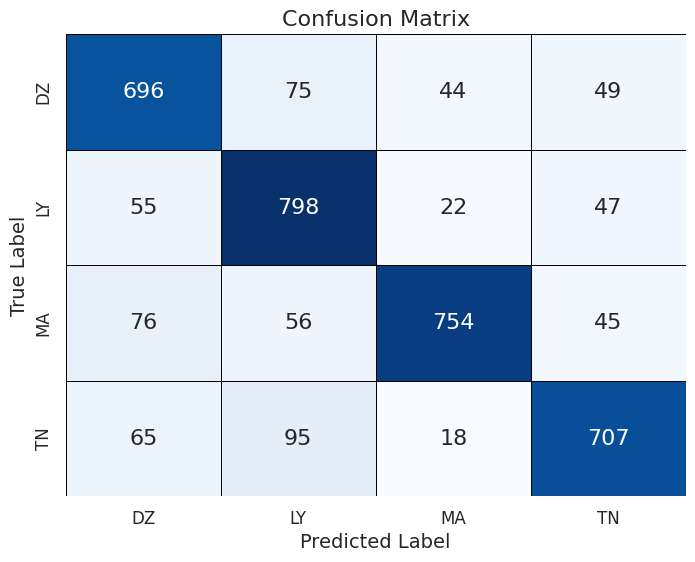

In [20]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns


model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        labels = labels.float()
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.6
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = metrics.accuracy_score(y_true, y_pred)
test_f1 = metrics.f1_score(y_true, y_pred, average='macro')
test_prec = metrics.precision_score(y_true, y_pred, average='macro')
test_recall = metrics.recall_score(y_true, y_pred, average='macro')

print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test F1 score: {:.4f}'.format(test_f1))
print('Test Precision: {:.4f}'.format(test_prec))
print('Test Recall: {:.4f}'.format(test_recall))

# Calculate confusion matrix
test_confusion_matrix = metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), labels=[0, 1, 2, 3])
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', ax=ax)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_xticklabels(["DZ", "LY", "MA", "TN"], fontsize=12)
ax.set_yticklabels(["DZ", "LY", "MA", "TN"], fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# **Testing**

In [17]:
# # Set the model to evaluation mode
# model.eval()
# device = "cuda"
# # Tokenize the new complaint and pad the sequence
# new_complaint = ['واش دير للعشى']
# #new_complaint  = ["شوكران علا هاد "]
# #new_complaint  = ["نبي نروح للحوش"]
# #new_complaint  = ["شبيك شتحب "]
# seq = tokenizer.texts_to_sequences(new_complaint)
# padded = pad_sequences(seq, maxlen=max_length)

# # Convert the padded sequence to a PyTorch tensor and move it to the device (e.g., GPU) if available
# padded_tensor = torch.LongTensor(padded).to("cpu")

# # Compute the model's prediction for the padded sequence
# with torch.no_grad():
#     pred = model(padded_tensor)

# # Move the prediction back to the CPU and convert to a numpy array
# pred = pred.cpu().numpy()

# # Map the prediction to a class label using the CLASS_DICT{'DZ': 0, 'LY': 1, 'MA': 2, 'TN': 3}
# CLASS_DICT = {1: "LY", 3: "TN", 2: "MA", 0: "DZ" }
# class_label = CLASS_DICT[np.argmax(pred)]

# # Print the prediction and the predicted class label
# print(class_label)